In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
import pylab

plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (18.0, 12.0)

%matplotlib inline

In [2]:
df = pd.read_csv("./data/facebook_combined.txt.gz", compression='infer', sep=" ")
#df = pd.read_csv("./data/twitter_combined.txt.gz", compression='infer', sep=" ", header=None)

print(len(df))
df.head()

88233


,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [3]:
df.columns = ["0", "1"]

In [4]:
nodes = list(set(df["0"]) | set(df["1"]))
nodes.sort()
nodes[:20]
nodes_to_idx = {n:i for i,n in enumerate(nodes)}

df_o = df
df = pd.DataFrame({"0": df["0"].apply(lambda x: nodes_to_idx[x]), 
                   "1": df["1"].apply(lambda x: nodes_to_idx[x])})
df.head()          

,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [5]:
df.describe()

,0,1
count,88233.000000,88233.000000
mean,1864.802908,2154.223533
std,910.275802,893.685198
min,0.000000,2.000000
25%,1160.000000,1600.000000
50%,1983.000000,2259.000000
75%,2423.000000,2631.000000
max,4031.000000,4038.000000


In [6]:
e = len(df)
v = max(np.max(np.unique(df["0"])), np.max(np.unique(df["1"]))) + 1
print(e,v)

88233 4039


## Passage au Laplacien

In [7]:
facebook2 = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
facebook2 = 1.0 * ((facebook2 + facebook2.T) !=0)

In [8]:
(facebook2 > 1)

<4039x4039 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [9]:
%time deg = np.array(facebook2.sum(axis=0))[0]

print(deg.shape)
print((deg == 0).sum())

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 670 µs
(4039,)
0


In [10]:
L = diags(np.array(facebook2.sum(axis=0))[0]) - facebook2
L = L.astype(np.float32)
L

<4039x4039 sparse matrix of type '<class 'numpy.float32'>'
	with 180505 stored elements in Compressed Sparse Row format>

In [11]:
from scipy.sparse.linalg import eigsh

In [12]:
import os.path
import pickle

n_clusters = int(L.shape[0]/40) 
neig = 2 + int(np.log2(n_clusters))

print(n_clusters, neig)

f_vec = "pkl/twitter_eigen_vec_%d.pkl" % neig
f_val = "pkl/twitter_eigen_val_%d.pkl" % neig

if os.path.isfile(f_vec) and os.path.isfile(f_val):
    
    with open(f_vec, "rb") as f:
        eigvec = pickle.load(f)
    with open(f_val, "rb") as f:
        eigval = pickle.load(f)
    
else:
    %time eigval, eigvec = eigsh(L, neig, which='SM', tol=1e-3)
    with open("pkl/twitter_eigen_vec.pkl", "wb") as f:
        pickle.dump(eigvec, f)
    with open("pkl/twitter_eigen_val.pkl", "wb") as f:
        pickle.dump(eigval, f)
# 15 min for 14 et 20...
# 21 min for 12

#%time eigval, eigvec = eigsh(L, neig, which='LM', tol=1e-2, sigma=0)
# very very long! => SystemError: gstrf was called with invalid arguments

eigval

100 8
CPU times: user 2.28 s, sys: 32 ms, total: 2.32 s
Wall time: 591 ms


array([ -3.69743975e-05,   1.82078369e-02,   2.90583726e-02,
         4.71756645e-02,   6.81909397e-02,   1.10504724e-01,
         1.63063005e-01,   6.78528368e-01], dtype=float32)

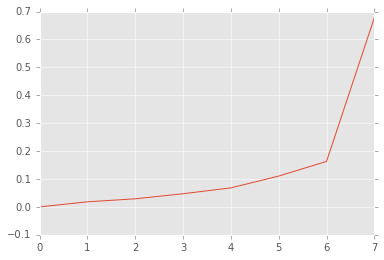

In [13]:
plt.plot(eigval)

In [14]:
e1 = eigvec[:,1]
print((e1>=0).sum(), (e1<0).sum())

3285 754


(2, 4039)


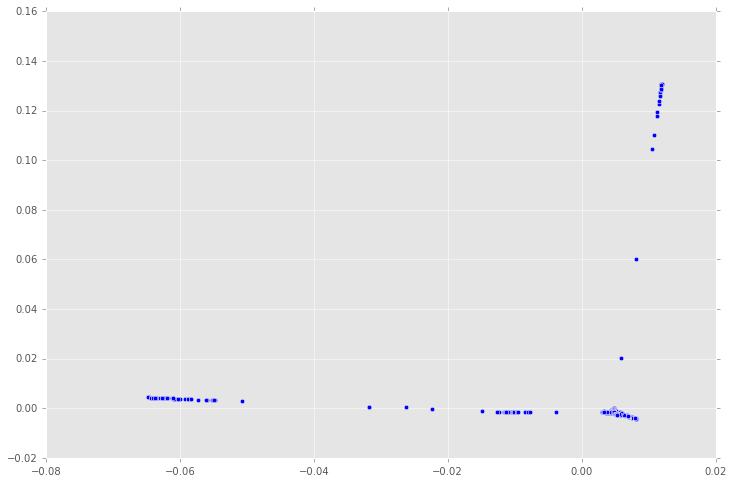

In [15]:
proj = eigvec[:, 1:3].T
print(proj.shape)

pylab.rcParams['figure.figsize'] = (12.0, 8.0)

plt.scatter(proj[0], proj[1])

## kmeans clustering

(4039, 2)
CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 22.5 ms
4
[[-0.01139406  0.01179204  0.00570953 -0.06279404]
 [-0.00165202  0.12812631 -0.00232425  0.00411796]]


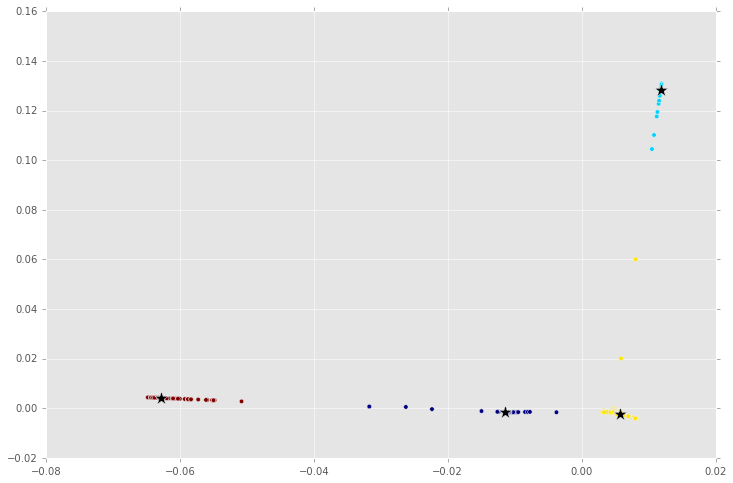

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

n_clusters = 4

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
# clf = DBSCAN(eps = 0.005)

print(proj.T.shape)

%time clusters = clf.fit_predict(proj.T)

print(len(np.unique(clusters)))

plt.scatter(proj[0], proj[1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

### Clustering plus poussé
**Attention:** ici nous normalisons les vecteurs propres.
Cela fait deux différences avec l'algorithme standard de spectral clustering
- normalisation vecteurs propres vs pas normalisation => je retire la normalisation
- 2^k-means sur k vecteurs propres contre k-means sur k vecteurs => je diminue le nombre de clusters

In [17]:
print(eigvec.min(axis=0), eigvec.max(axis=0), eigvec.mean(axis=0))
print(1/(eigvec.max(axis=0) - eigvec.min(axis=0)))

[ 0.01571777 -0.06478774 -0.00421704 -0.03772661 -0.03585397 -0.03761352
 -0.03011889 -0.03773851] [ 0.01574289  0.01196385  0.13086525  0.02744743  0.02287051  0.02637916
  0.02097226  0.153216  ] [  1.57349594e-02  -3.32823834e-06  -3.38827107e-07  -5.19645073e-06
  -4.57357544e-07   2.82631390e-07   4.91122201e-08   5.90291105e-09]
[  3.98035977e+04   1.30290470e+01   7.40289497e+00   1.53435316e+01
   1.70286713e+01   1.56267853e+01   1.95728645e+01   5.23684883e+00]


In [18]:
eigvec_n = (eigvec-eigvec.min(axis=0)) / (eigvec.max(axis=0) - eigvec.min(axis=0))
print(eigvec_n.shape, eigvec.shape)
print(eigvec_n.mean(axis=0))

(4039, 8) (4039, 8)
[ 0.68431652  0.8440792   0.03121582  0.57877976  0.61053771  0.58778292
  0.58951384  0.19763093]


n_clusters = 40
(4039, 7)
CPU times: user 60 ms, sys: 16 ms, total: 76 ms
Wall time: 669 ms
40


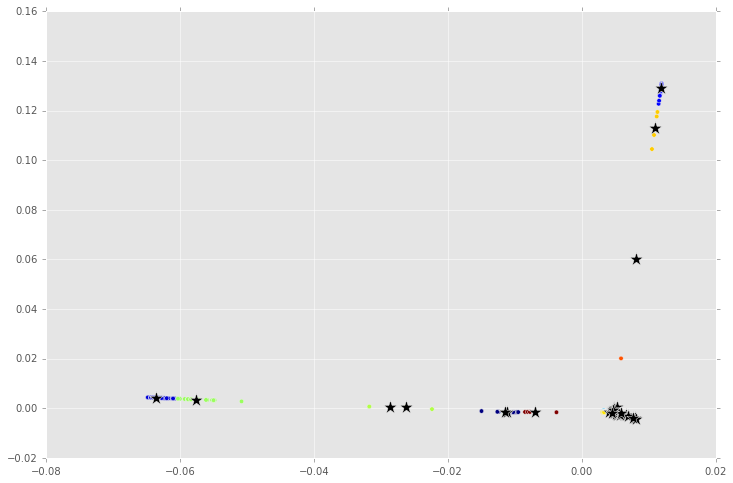

In [19]:
#n_clusters = int(v/40)
n_clusters = int(v/100)
print("n_clusters = %d" % n_clusters)

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, n_jobs=4)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
#clf = DBSCAN(eps = 0.0005)

#X = eigvec_n[:,1:]
X = eigvec[:,1:]

print(X.shape)
%time clusters = clf.fit_predict(X)
print(len(np.unique(clusters)))

plt.scatter(X[:,0], X[:,1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    # print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

## display clustered graphs

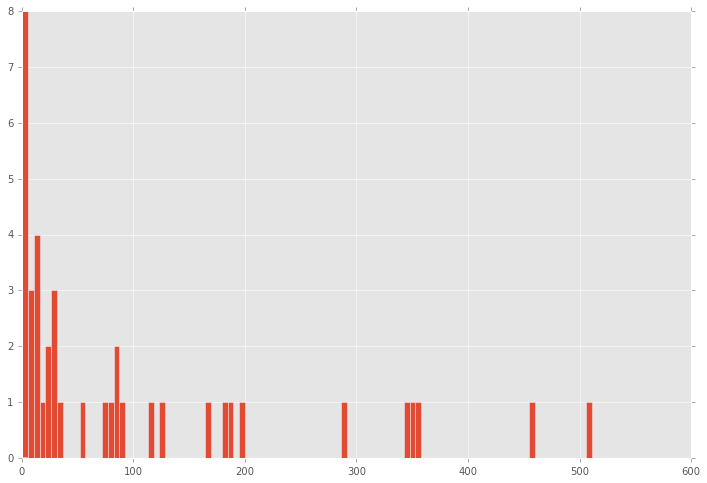

In [20]:
vc = pd.Series(clusters).value_counts()
vc.hist(bins=100)

In [21]:
pd.DataFrame({'cnt': vc}).groupby(["cnt"]).size()

cnt
1      4
3      2
4      2
8      1
9      1
11     1
13     1
15     2
16     1
19     1
25     2
27     1
28     2
34     1
55     1
74     1
79     1
83     1
86     1
92     1
118    1
127    1
167    1
180    1
187    1
197    1
288    1
344    1
351    1
354    1
455    1
511    1
dtype: int64

In [22]:
import networkx as nx

%time g = nx.Graph(list(df.to_records(index=False)))
g

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


Cluster #5 is of size 55
pseudo-degree of cluster is 14


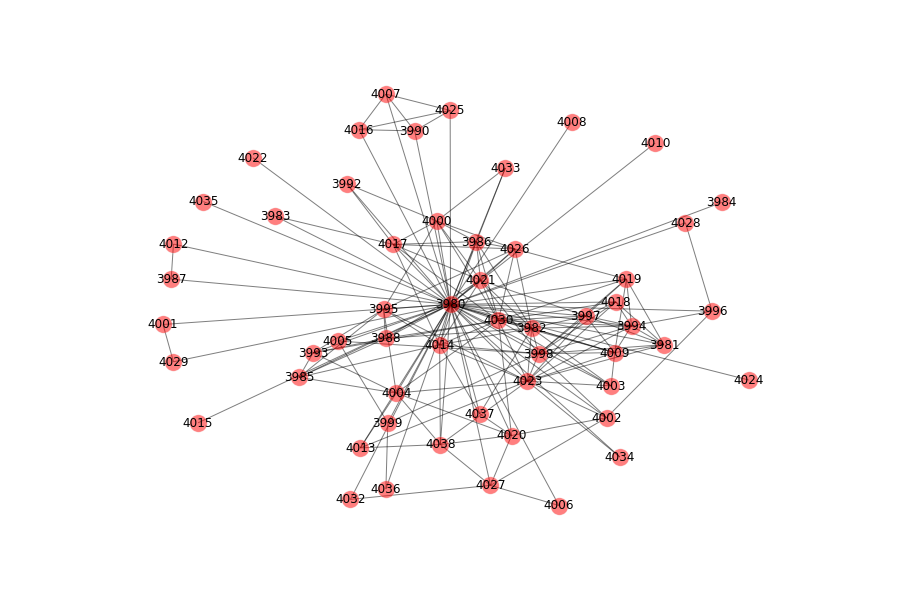

In [23]:
from IPython.html.widgets import interact
import gmet
import graph_helpers

@interact
def plot(cl = ('5', '6', '7', '8', '10', '20', '30', '27', '215', '42', '1150'), 
         degree=("0", "1", "2"), layout=("spring", "std", "spectral")):
    cl = int(cl)
    print("Cluster #%d is of size %d" % (cl, (clusters == cl).sum()))
    
    print("pseudo-degree of cluster is %d" % gmet.group_edge_degree(facebook2, clusters == cl))
    
    graph_helpers.plot_subgraph_links(facebook2, clusters == cl, int(degree), layout=layout, graph=g)

In [25]:
n = 46

print((clusters[n]), (clusters == clusters[n]).sum())
print((df["0"] == n).sum())
print((df["1"] == n).sum())
df[(df["1"] == n) | (df["0"] == n)]

18 127
4
1


,0,1
44,0,46
993,46,143
994,46,175
995,46,177
996,46,278


In [26]:
df.head()

,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 106 ms
count     40.000000
mean     108.425000
std      140.725572
min        1.000000
25%        9.750000
50%       65.000000
75%      155.500000
max      702.000000
dtype: float64


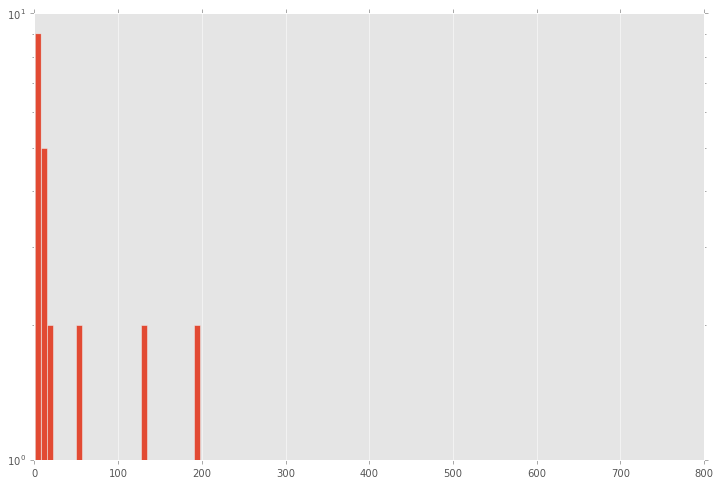

In [27]:
from gmet import group_vertex_degree, group_edge_degree

%time all_degs = [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)]

print(pd.Series(all_degs).describe())
_ = plt.hist(all_degs, bins=100)
plt.yscale("log")

### Optimisation à faire
Il faudrait optimiser le calcul des deux "degrés" en le faisant en masse par un big produit matriciel

### Compléments à faire
- implémenter d'autres métriques (cf littérature) comme le RatioCut = sigma cuts / taille et Ncut = sigma cuts / vol
- remettre en non normalisé!
- diminuer le k du k-means

In [28]:
from gmet import group_vertex_degree, group_edge_degree

%time metrics = pd.DataFrame({'sz': [(clusters == cl).sum() for cl in range(n_clusters)], \
                          'vdeg': [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)], \
                          'edeg': [group_edge_degree(facebook2, clusters == i) for i in range(n_clusters)]})

metrics["vratio"] = metrics.vdeg / metrics.sz
metrics["eratio"] = metrics.edeg / metrics.sz

metrics.describe()

CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 188 ms


,edeg,sz,vdeg,vratio,eratio
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,324.450000,100.975000,108.425000,2.756417,5.447198
std,433.177642,135.682035,140.725572,4.034568,6.179768
min,2.000000,1.000000,1.000000,0.027778,0.238889
25%,24.500000,10.500000,9.750000,0.557946,1.466175
50%,170.500000,28.000000,65.000000,2.000000,2.904987
75%,369.250000,137.000000,155.500000,3.163690,7.650000
max,1605.000000,511.000000,702.000000,18.777778,30.555556


In [29]:
metrics[metrics.vratio < 0.5].describe()

,edeg,sz,vdeg,vratio,eratio
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,129.375000,108.625000,19.875000,0.148057,1.083909
std,166.818068,99.278738,28.215687,0.120438,0.698908
min,11.000000,11.000000,1.000000,0.027778,0.238889
25%,18.500000,22.750000,2.750000,0.090909,0.813636
50%,35.000000,91.000000,5.000000,0.111181,1.087244
75%,196.000000,170.250000,24.750000,0.145833,1.256076
max,414.000000,288.000000,70.000000,0.419162,2.479042


In [30]:
metrics[metrics.vratio < 0.5][metrics.vdeg < 10].describe()

/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,edeg,sz,vdeg,vratio,eratio
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,23.000000,57.400000,3.200000,0.090919,0.764687
std,12.747549,70.627898,1.788854,0.038711,0.481412
min,11.000000,11.000000,1.000000,0.027778,0.238889
25%,14.000000,16.000000,2.000000,0.090909,0.254545
50%,20.000000,25.000000,3.000000,0.090909,1.000000
75%,27.000000,55.000000,5.000000,0.120000,1.080000
max,43.000000,180.000000,5.000000,0.125000,1.250000


In [31]:
metrics[metrics.eratio < 0.5].describe()

,edeg,sz,vdeg,vratio,eratio
count,2.000000,2.000000,2.0,2.000000,2.000000
mean,28.500000,117.500000,5.0,0.059343,0.246717
std,20.506097,88.388348,0.0,0.044641,0.011071
min,14.000000,55.000000,5.0,0.027778,0.238889
25%,21.250000,86.250000,5.0,0.043561,0.242803
50%,28.500000,117.500000,5.0,0.059343,0.246717
75%,35.750000,148.750000,5.0,0.075126,0.250631
max,43.000000,180.000000,5.0,0.090909,0.254545


0.505


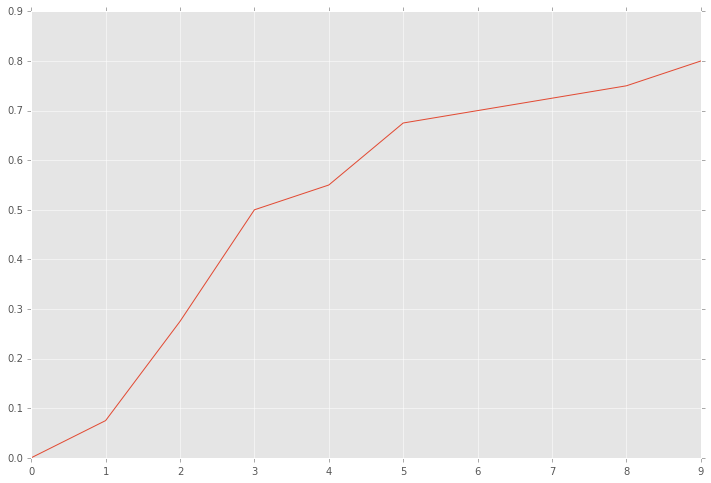

In [32]:
def eratios(df):
    return np.array([len(metrics[metrics.eratio < i])/len(metrics) for i in range(10)])

def perf(df):
    return (eratios(df)/10).sum()

er = eratios(metrics)

print (perf(metrics))

plt.plot(er)

In [41]:
from imp import reload
import gmet
reload(gmet)

metrics["ratio_cut"] = gmet.ratio_cut_list(facebook2, clusters)
metrics["n_cut"] = gmet.n_cut_list(facebook2, clusters)

metrics.describe()

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,324.450000,100.975000,108.425000,2.756417,5.447198,5.447198,0.449978
std,433.177642,135.682035,140.725572,4.034568,6.179768,6.179768,0.355230
min,2.000000,1.000000,1.000000,0.027778,0.238889,0.238889,0.011373
25%,24.500000,10.500000,9.750000,0.557946,1.466175,1.466175,0.081353
50%,170.500000,28.000000,65.000000,2.000000,2.904987,2.904987,0.348588
75%,369.250000,137.000000,155.500000,3.163690,7.650000,7.650000,0.744808
max,1605.000000,511.000000,702.000000,18.777778,30.555556,30.555556,1.000000


Même avec une centaine de vertex par sous-graphe en moyenne, on a la moitié des sous-graphes à moins de 8 composantes => OK pour diminuer le nombre de clusters!

In [38]:
metrics[metrics.sz >= 4].describe()

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,380.470588,118.500000,126.500000,2.615393,5.722193,5.722193,0.370562
std,447.435401,140.168135,145.455033,4.274890,6.613659,6.613659,0.319649
min,11.000000,4.000000,1.000000,0.027778,0.238889,0.238889,0.011373
25%,44.750000,16.750000,19.000000,0.514011,1.362258,1.362258,0.062289
50%,253.500000,64.500000,83.500000,1.513333,2.904987,2.904987,0.299860
75%,404.500000,176.750000,178.750000,2.764803,8.015686,8.015686,0.712185
max,1605.000000,511.000000,702.000000,18.777778,30.555556,30.555556,0.934066


In [39]:
metrics[(metrics.sz >=4) & (metrics.ratio_cut < 0.2)]

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut


In [40]:
print(metrics.ratio_cut.sum(), metrics.n_cut.sum())

217.88790575091198 17.99910090602731
